### In this notebook we will calibrate forward model from monochromator measurements, and make a dataset. 

To calibrate, I need the dispersion from the center, the standard deviation of gaussian of each peak

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os, sys
main_dir = os.path.abspath('../../')
sys.path.insert(0, main_dir)

import models.helper as hlp
from models.custom.model import *
import forward.fourier.method as fwd
from forward.fourier.kernel_creator import create_fourier_kernel
from skimage.feature import peak_local_max
from scipy.ndimage import center_of_mass, shift

from torchvision.transforms import GaussianBlur


import gc
def clear_gpu():
    gc.collect()
    torch.cuda.empty_cache()

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")


%load_ext autoreload
%autoreload 2

/home/s/Sunny.Howard/anaconda3/envs/torchenv/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/s/Sunny.Howard/anaconda3/envs/torchenv/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
dir = '/project/agdoepp/Experiment/Hyperspectral_Calibration_FTS/microlens_18012024_calibration/'
data_dir = '/project/agdoepp/Experiment/Hyperspectral_Calibration_FTS/microlens_18012024_new/'

files = os.listdir(dir)

kernel = torch.load(data_dir+'microlens_kernel.pt').to(device)

In [3]:
order = np.argsort([int(f[:3]) for f in files])
files = np.array(files)[order]
files = files[25:-24]

bitdepth = 16
# orientation = 'straight'

cube = torch.stack([torch.tensor((np.load(dir + file) / 2**bitdepth).astype(np.float32)) for file in files])# if str(bitdepth) in file and orientation in file and 'tiff' in file])

cube = torch.nan_to_num(cube, nan = torch.nan_to_num(cube).max())

n_wl = cube.shape[0]
mid_wl = n_wl // 2
# image = torch.mean(images, dim=(0))

# image = image[700:1200,950:1450]

# cube = cube / torch.max(cube)

# bitrate = 1 / images.unique()[1] 

blurred_cube = GaussianBlur(kernel_size=25, sigma=(10))(cube.unsqueeze(0))

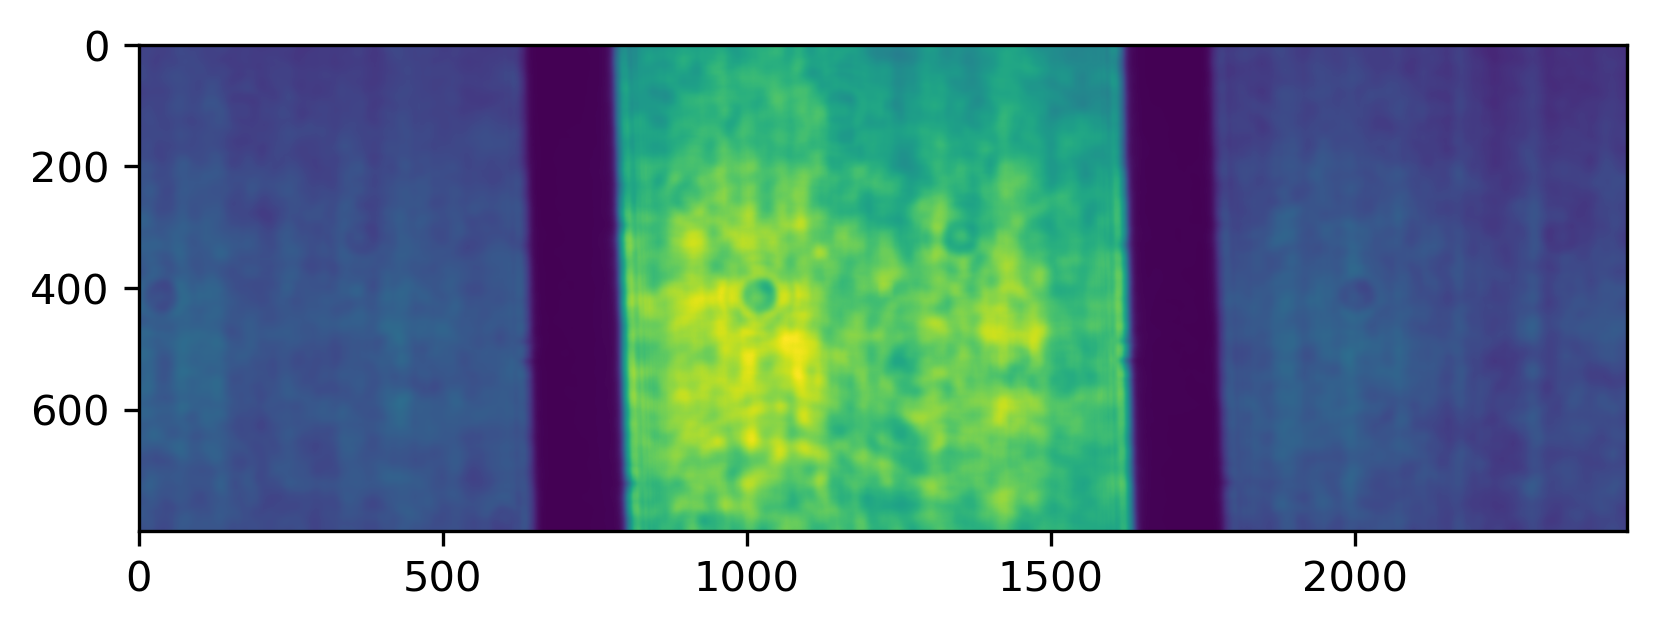

In [4]:
plt.figure(dpi=300)
plt.imshow(blurred_cube[0,-1])

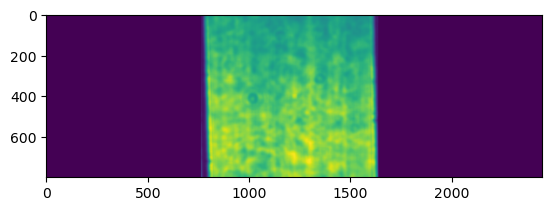

In [5]:
just_funda = blurred_cube.clone()

just_funda[:,:,:,0:765] = 0
just_funda[:,:,:,1640:] = 0


plt.imshow(just_funda[0,0])

In [6]:
dispersed_cube = fwd.disperser.disperse_all_orders(just_funda.to(device), kernel.to(device)).cpu()


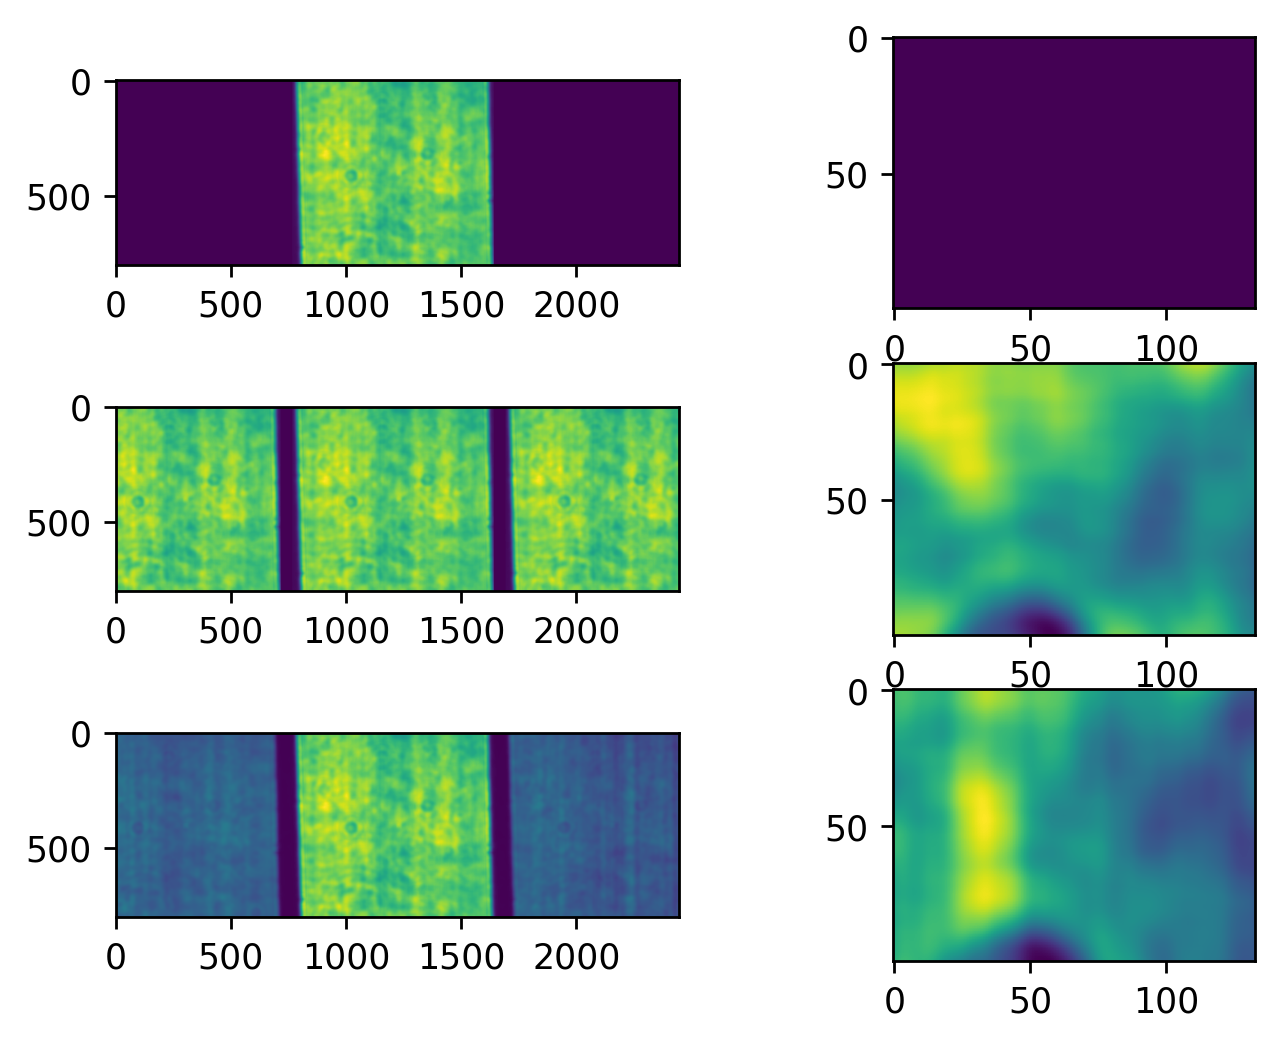

In [7]:
# dispersed_cube = fwd.disperser.disperse_all_orders(just_funda, kernel)
fig,ax = plt.subplots(3,2,dpi=250)
ax[0,0].imshow(just_funda[0,mid_wl].cpu().numpy())
ax[1,0].imshow(dispersed_cube[0,mid_wl].cpu(),vmax= just_funda[0,mid_wl].cpu().max())
ax[2,0].imshow(blurred_cube[0,mid_wl],vmax= just_funda[0,mid_wl].cpu().max())

ax[0,1].imshow(just_funda[0,mid_wl,300:400,1900:2033].cpu().numpy())
ax[1,1].imshow(dispersed_cube[0,mid_wl,300:400,1900:2033].cpu())
ax[2,1].imshow(blurred_cube[0,mid_wl,300:400,1900:2033])


In [8]:
grating_modulation = (blurred_cube / dispersed_cube)

grating_modulation = torch.nan_to_num(grating_modulation)
grating_modulation[grating_modulation > 5] = 0 

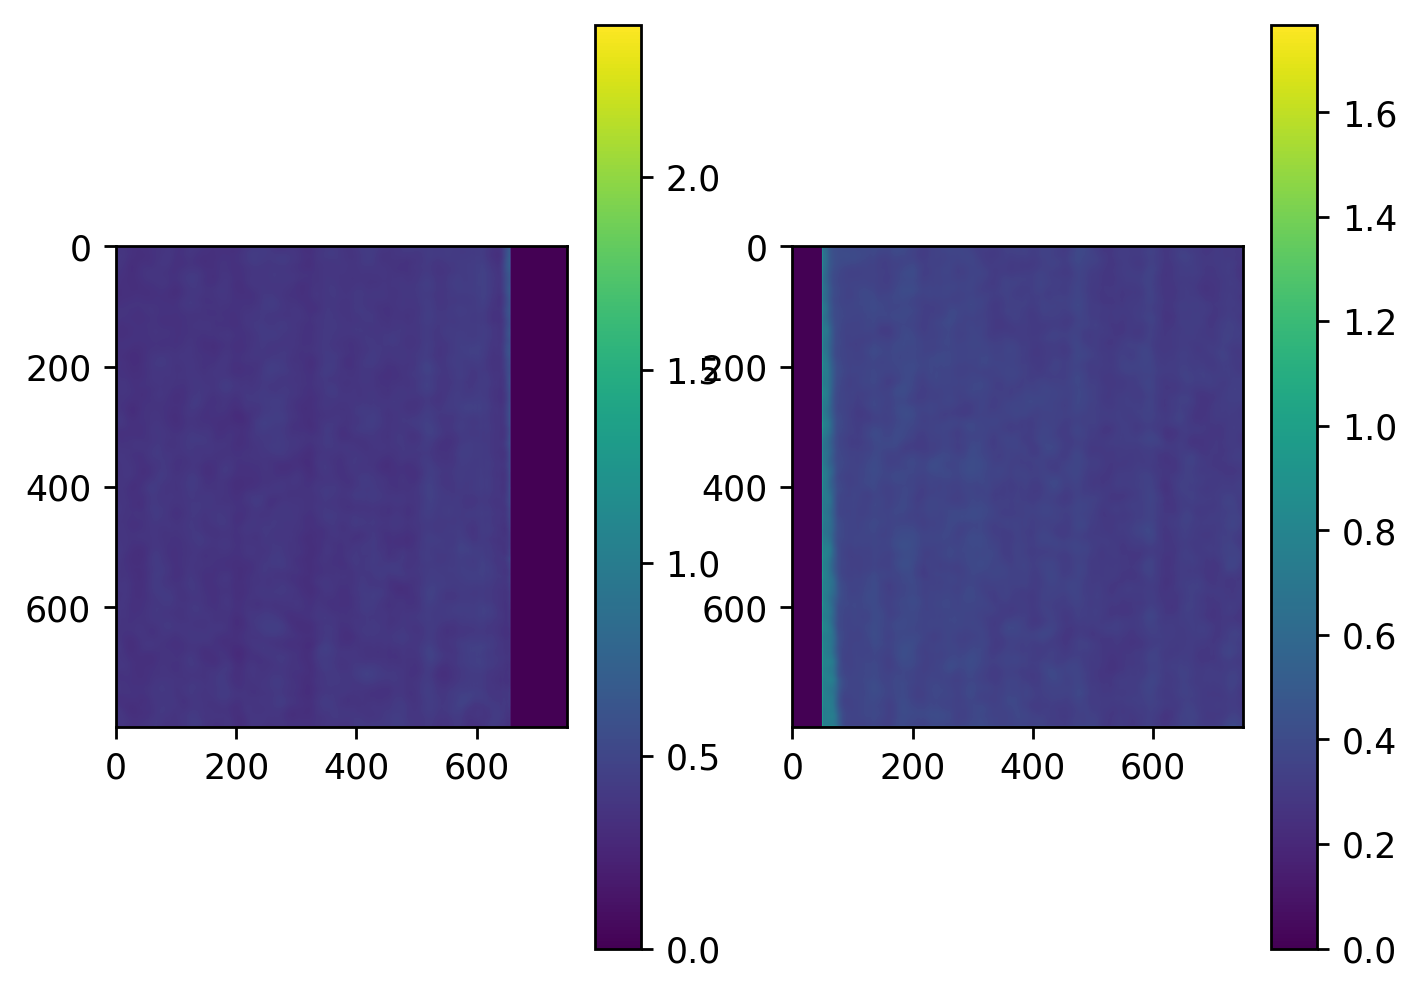

In [9]:
wl = -1

fig,ax = plt.subplots(1,2,dpi=250)
a= ax[0].imshow(grating_modulation[0,wl,:,:750])
b = ax[1].imshow(grating_modulation[0,wl,:,-750:])
fig.colorbar(a, ax=ax[0])
fig.colorbar(b, ax=ax[1])
# plt.colorbar()

In [30]:
torch.save(grating_modulation[...,:750], data_dir+'microlens_grating_modulation_m1.pt')
torch.save(grating_modulation[...,-750:], data_dir+'microlens_grating_modulation_p1.pt')

